<a href="https://colab.research.google.com/github/bramvandeurzen934/Group16_ECG/blob/main/assignment_ecg_SVC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment template -- ECG data

## Data loading and exploration

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [52]:
# Run this to use from colab environment
!git clone https://github.com/bramvandeurzen934/Group16_ECG.git

import zipfile
import os
import pandas as pd

with zipfile.ZipFile('/content/Group16_ECG/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/Group16_ECG')

data = pd.read_csv('/content/Group16_ECG/ecg_data.csv', index_col=0)

labels = data['label']
feature_data = data.drop('label',axis = 1)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

fatal: destination path 'Group16_ECG' already exists and is not an empty directory.
The number of samples: 827
The number of columns: 9001


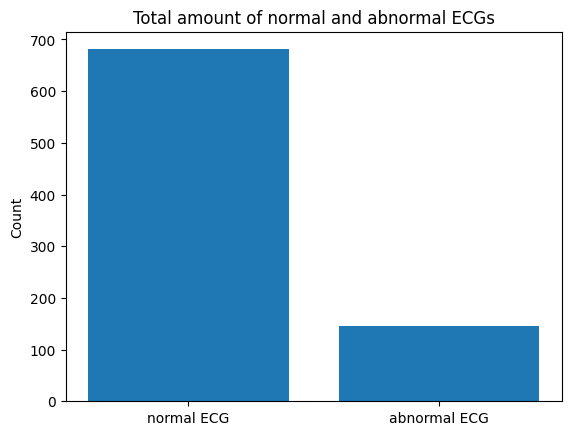

In [53]:
# Distribution labels
import matplotlib.pyplot as plt
text = ['normal ECG','abnormal ECG']
lst_labels = list(labels)
frequentie = [lst_labels.count(0), lst_labels.count(1)]
plt.bar(text, frequentie)
plt.title('Total amount of normal and abnormal ECGs')
plt.ylabel('Count')
plt.show()

This figure shows us that the data is unbalanced. The number of labels differs between the normal and abnormal ECGs. Based on the literature we will look for methods to compensate for the unbalanced data.

In [54]:
# Testen per feature of het normaal verdeeld is per groep
from scipy.stats import shapiro

data_gezond = data[data["label"] == 0]
data_afwijkend = data[data["label"] == 1]

data_gezond = data_gezond.drop('label',axis = 1)
data_afwijkend = data_afwijkend.drop('label',axis = 1)

niet_nrml_vd_gezond = dict()
for kolomnaam in data_gezond.columns:
  statistiek = shapiro(list(data_gezond[kolomnaam]))
  if statistiek[1] > 0.05:
    niet_nrml_vd_gezond[kolomnaam] = statistiek[1]
print(niet_nrml_vd_gezond)

niet_nrml_vd_afwijkend = dict()
for kolomnaam in data_afwijkend.columns:
  statistiek = shapiro(list(data_afwijkend[kolomnaam]))
  if statistiek[1] > 0.05:
    niet_nrml_vd_afwijkend[kolomnaam] = statistiek[1]
print(niet_nrml_vd_afwijkend)



{}
{}


Based on the shapiro test with a p-value of 0.05 we found that all features are normally distributed. Therefore, we will use mean and standard deviation to describe the data.

### Missing values in data

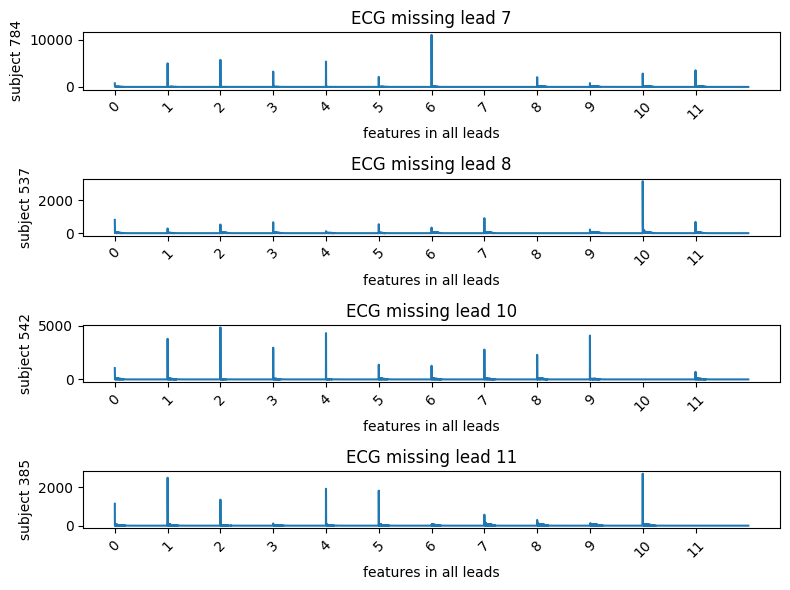

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(4, 1, figsize=(8, 6))

sns.lineplot(x = data.columns,y=data.iloc[784,:],ax = axes[0])
sns.lineplot(x = data.columns,y=data.iloc[537,:],ax = axes[1])
sns.lineplot(x = data.columns,y=data.iloc[542,:],ax = axes[2])
sns.lineplot(x = data.columns,y=data.iloc[385,:],ax = axes[3])


axes[0].set_xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)
axes[1].set_xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)
axes[2].set_xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)
axes[3].set_xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)

axes[0].set(ylabel = 'subject 784',
            xlabel = 'features in all leads',
            title = 'ECG missing lead 7')
axes[1].set(ylabel = 'subject 537',
            xlabel = 'features in all leads',
            title = 'ECG missing lead 8')
axes[2].set(ylabel = 'subject 542',
            xlabel = 'features in all leads',
            title = 'ECG missing lead 10')
axes[3].set(ylabel = 'subject 385',
            xlabel = 'features in all leads',
            title = 'ECG missing lead 11')

plt.tight_layout()

plt.show()

### Sorting the features on greatest significant differences between abnormal and normal ECG
A two tailed T-test is performed on the data per feature. The test will find if there is a significant difference between the normal and abnormal ECG per feature. The features are sorted based on the p-value. The five most distinctive features are shown in the pairplot.

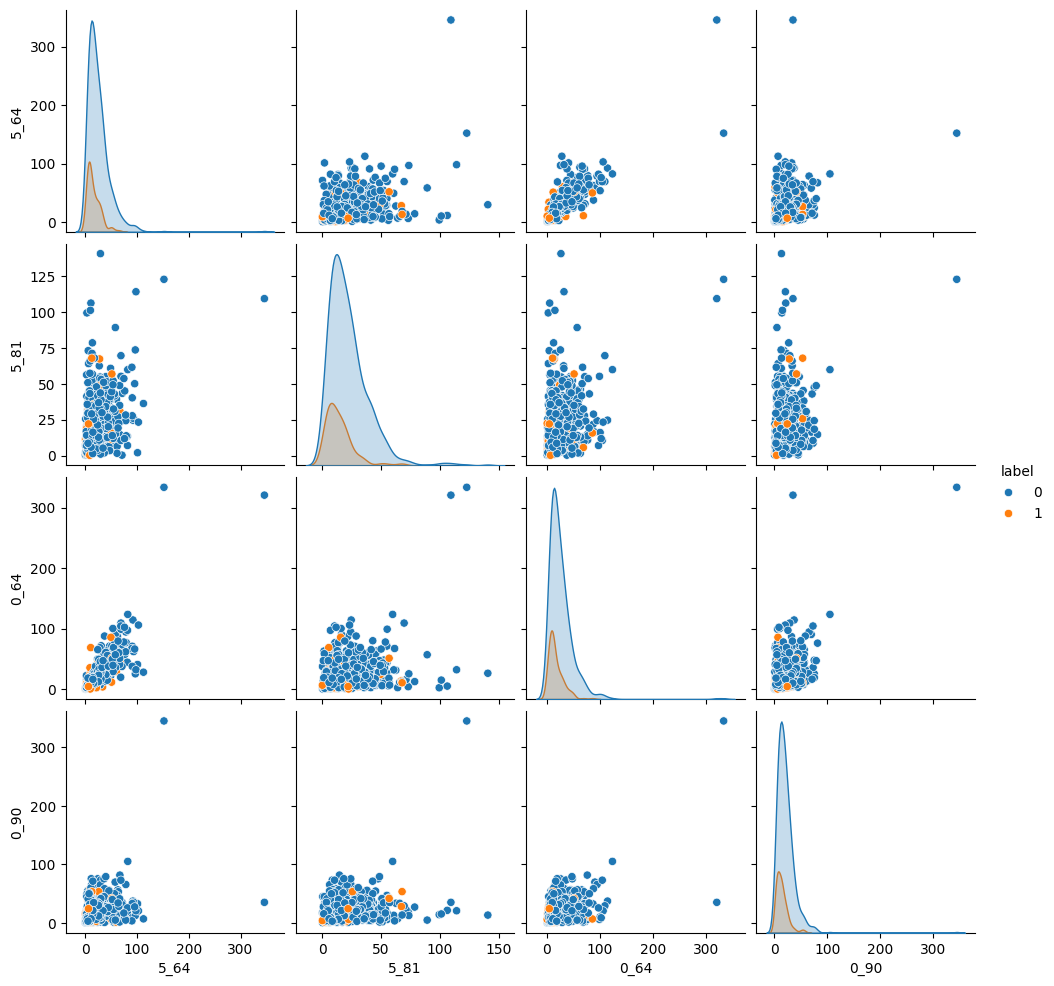

In [56]:
from scipy.stats import ttest_ind
import numpy as np
import seaborn as sns

p_values = ttest_ind(a=data_gezond, b=data_afwijkend, axis = 0, equal_var=False)

dict_p_values = dict()
for kolom in data_gezond.columns:
  p_value = ttest_ind(data_gezond[kolom],data_afwijkend[kolom],equal_var=False)
  dict_p_values[kolom] = p_value[1]

dict_sorted_p_values = dict(sorted(dict_p_values.items(),key = lambda x:x[1]))
features_sorted = list(dict_sorted_p_values.keys())

most_sign_data = data[features_sorted[:4] + ["label"]]
sns.pairplot(data = most_sign_data,hue = "label")

In this figure we observe that the following two things:
*   The features are noramlly distributed for the normal and abnormal ECGs and outliers a present pulling the distribution to the right. (this corresponds to the shapiro tests we did before)
*  In the graphs where features are plotted against each other, we see that the samples are linearly distributed (a linear kernel to describe the data structure seems the most appropriate option)



## Data preprocessing

In this section we will perform imputation (missing values), normalisation (scaling) and oversampling to overcome unbalanced data.

In [57]:
from sklearn.model_selection import StratifiedShuffleSplit

X = data.copy()
X = X.drop('label',axis = 1)
y = data['label']

#Performing a stratified train-test split
sss =  StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

train_index, test_index = next(sss.split(X, y))

#Selecting the training and testing samples
X_train = X.iloc[train_index]
X_test  = X.iloc[test_index]
y_train = y.iloc[train_index]
y_test  = y.iloc[test_index]


## Printing of the results
print(f'splitted in stratified train-test split with {len(X_train)} training samples and {len(X_train)} testing samples')
print(f'Trainset (n={len(X_train)}): {round(sum(y_train == 1)/(sum(y_train == 0)+   sum(y_train == 1)),3)*100}% of samples is abnormal')
print(f'Testset (n={len(X_test)}): {round(sum(y_test == 1)/(sum(y_test == 0)+ sum(y_test == 1)),3)*100}% of samples is abnormal')

splitted in stratified train-test split with 661 training samples and 661 testing samples
Trainset (n=661): 17.7% of samples is abnormal
Testset (n=166): 17.5% of samples is abnormal


### Choosing scaling method

In [58]:
from sklearn import preprocessing

# standardscaler
scaler_st = preprocessing.StandardScaler()
scaler_st.fit(X_train)
X_train_st_scaled = pd.DataFrame(scaler_st.transform(X_train),columns = X_train.columns,index = X_train.index)
X_test_st_scaled = scaler_st.transform(X_test)

# smin max scaler
scaler_max = preprocessing.MinMaxScaler()
scaler_max.fit(X_train)
X_train_max_scaled = pd.DataFrame(scaler_max.transform(X_train),columns = X_train.columns,index = X_train.index)
X_test_max_scaled = scaler_max.transform(X_test)

# robust scaler
scaler_rob = preprocessing.RobustScaler()
scaler_rob.fit(X_train)
X_train_rob_scaled = pd.DataFrame(scaler_rob.transform(X_train),columns = X_train.columns,index = X_train.index)
X_test_rob_scaled = scaler_rob.transform(X_test)

# chose scaler is robust scaler
X_train_scaled = scaler_rob.transform(X_train)
X_test_scaled = scaler_rob.transform(X_test)

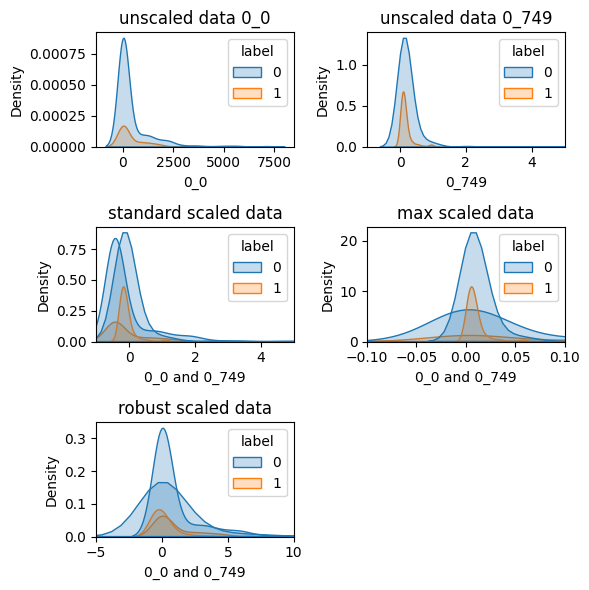

In [59]:
# figures showing the scalers
fig, axs = plt.subplots(3,2,figsize = [6,6])

sns.kdeplot(data = X_train,x = '0_0',hue = y_train,fill = True, ax = axs[0,0])
axs[0,0].set(title = 'unscaled data 0_0')

sns.kdeplot(data = X_train,x = '0_749',hue = y_train,fill = True, ax = axs[0,1])
axs[0,1].set(title = 'unscaled data 0_749',
             xlim = [-1,5])

sns.kdeplot(data = X_train_st_scaled,x = '0_0',hue = y_train,fill = True, ax = axs[1,0])
sns.kdeplot(data = X_train_st_scaled,x = '0_749',hue = y_train,fill = True, ax = axs[1,0])
axs[1,0].set(title = 'standard scaled data',
             xlim = [-1,5],
             xlabel = '0_0 and 0_749')

sns.kdeplot(data = X_train_max_scaled,x = '0_0',hue = y_train,fill = True, ax = axs[1,1])
sns.kdeplot(data = X_train_max_scaled,x = '0_749',hue = y_train,fill = True, ax = axs[1,1])
axs[1,1].set(title = 'max scaled data',
             xlim = [-0.1,0.1],
             xlabel = '0_0 and 0_749')

sns.kdeplot(data = X_train_rob_scaled,x = '0_0',hue = y_train,fill = True, ax = axs[2,0])
sns.kdeplot(data = X_train_rob_scaled,x = '0_749',hue = y_train,fill = True, ax = axs[2,0])
axs[2,0].set(title = 'robust scaled data',
             xlim = [-5,10],
             xlabel = '0_0 and 0_749')

axs[2,1].remove()

plt.tight_layout()

Conclusions:
*   Minimum maximum scaler will not be used. When outliers are present such as in feature 0_0 we observe that distribution of feature 0_0 gets flattened. Inliers are cropped with the max scaler resulting in a deviated distribution from the original feature.
*   Robust scaler: scales the data with the IQR and median. It retains the distribution of the data especially when the distribution is not Gaussian. It is particularly useful when there is a non normal distribution.
*   Standard scaler: as there is a bit of skewness in the data of feature 0_0 we see when using the mean and standard deviation that the distribution shifts to the left. Because of outliers you can observe that the data inclines to the right (there data is not perfectly normal distributed). **When you are using standards scaled data, the mean is shifted towards the outliers and with robust scaling we don't have problems with this. **

Overall conclusions:
*   Robust scaler is preferred (other benefits: more stable and versatile)
*   Skewness is present (caused by outliers)
*   Normal distribution is perceivable (as tested by Eva before)

### Preprocessing
In this section we apply the computations we discussed in the literature/experiments.

In [102]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
import numpy as np
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.decomposition import PCA, KernelPCA
from sklearn.linear_model import Lasso
from sklearn.feature_selection import mutual_info_classif, SelectKBest, RFECV
import seaborn as sns
import matplotlib.pyplot as plt


####### PREPROCESSING #######
# 1) Replacing the zero values with their mean #
X_train.replace(0, np.nan, inplace=True)
imp_median = SimpleImputer(missing_values = np.nan, strategy = 'median')
imp_median.fit(X_train)
X_train_imputed = pd.DataFrame(imp_median.transform(X_train),columns = X_train.columns,index = X_train.index)
X_test_imputed = pd.DataFrame(imp_median.transform(X_test),columns = X_test.columns, index = X_test.index)

# 2) Normalizing the data #
# robust scaler
scaler = preprocessing.RobustScaler()
scaler.fit(X_train_imputed)
X_train_scaled = pd.DataFrame(scaler.transform(X_train_imputed),columns = X_train_imputed.columns,index = X_train_imputed.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed),columns = X_test_imputed.columns,index = X_test_imputed.index)

# 3) Oversampling
# oversampler = SMOTE()
# X_train_oversampled,y_train_oversampled = oversampler.fit_resample(X_train_scaled,y_train)

Due to oversampling the labels are equally distributed (n = 544 for each label)

## Feature selection
We will perform feature selection because we observed the curse of dimensionality (9000 features). Our first goal is to reduce the number of features. We first chose other/simpler feature reduction techniques than PCA because PCA is hard to interpret by clinicians.


In [116]:
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel, mutual_info_classif
from imblearn.over_sampling import RandomOverSampler

X_train = X_train_scaled
X_test = X_test_scaled


# Display the weights and compute error for multiple values for alpha
n_alphas = 10
alphas = np.logspace(-4, -1, n_alphas)
scores = []
n_features = []
features_lasso = {}
feature_names_lasso = {}

for alpha in alphas:
  # # Fit Lasso on the training data
  # lasso = Lasso(alpha=alpha)  # Choose appropriate alpha
  # lasso.fit(X_train, y_train)
  print(alpha)
  # # Extract non-zero coefficients
  # selected_features_lasso = lasso.coef_ != 0
  # print(f'number of selected features in {alpha}',selected_features_lasso.sum())
  # features_lasso[alpha] = X_train.loc[:,selected_features_lasso]
  # feature_names_lasso[alpha] = X_train.loc[:,selected_features_lasso].columns
  # # Select features from the original dataset
  # X_train_selected = X_train.loc[:, selected_features_lasso]
  lasso = Lasso(alpha = alpha)
  # Define the pipeline
  pipeline = Pipeline([
       ('selectmodel',SelectFromModel(lasso)),
       ('sampling',RandomOverSampler(random_state=1)),
       ('model', SVC(random_state=1)),                  # Step 4: SMOTE for oversampling
  ])

  # Define parameter grid for GridSearchCV
  param_grid = {
      'model__kernel': ['linear']
  }
  # Create GridSearchCV object
  grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5,verbose = 2,error_score='raise',scoring = 'f1')

  # Fit GridSearchCV to the training data
  grid_search.fit(X_train, y_train)

  # Print best parameters and best score
  print(f"Best parameters {alpha}:", grid_search.best_params_)
  print(f"Best score F1 {alpha}:", grid_search.best_score_)

  scores.append(grid_search.cv_results_['mean_test_score'])

    # Access the SelectFromModel transformer from the pipeline after fitting
  selectmodel = grid_search.best_estimator_.named_steps['selectmodel']
  selected_features = sum(selectmodel.get_support())

  n_features.append(selected_features)

  # Evaluate the best model on the test data
  # models_lasso.append(lasso)

# select best model
#index_max = scores.index(max(scores))
#best_model_lasso = models_lasso[index_max]

0.0001
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.910e-01, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   6.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.710e-01, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   5.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.888e-01, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   5.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.657e-01, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   6.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.509e-01, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   6.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.837e-01, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Best parameters 0.0001: {'model__kernel': 'linear'}
Best score F1 0.0001: 0.4982539682539683
0.00021544346900318845
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.106e-01, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   5.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.292e-01, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   6.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.853e-01, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   6.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.048e-01, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   6.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.243e-01, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   6.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.899e-01, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Best parameters 0.00021544346900318845: {'model__kernel': 'linear'}
Best score F1 0.00021544346900318845: 0.4542758545665523
0.00046415888336127773
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.479e-01, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   4.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.535e-01, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   5.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.682e-01, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   5.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.641e-01, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   5.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.111e-01, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   5.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.151e+00, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Best parameters 0.00046415888336127773: {'model__kernel': 'linear'}
Best score F1 0.00046415888336127773: 0.4542789839406677
0.001
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.729e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   6.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.545e-01, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   4.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.515e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   4.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.649e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   5.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.394e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   4.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.895e+00, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Best parameters 0.001: {'model__kernel': 'linear'}
Best score F1 0.001: 0.4680449280449281
0.002154434690031882
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.918e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   5.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.815e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   5.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.628e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   6.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.636e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   5.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.071e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   4.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.556e+00, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Best parameters 0.002154434690031882: {'model__kernel': 'linear'}
Best score F1 0.002154434690031882: 0.46204582789948645
0.004641588833612777
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.516e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   5.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.776e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   5.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.495e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   5.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.320e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   4.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.837e+00, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   5.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.358e+00, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Best parameters 0.004641588833612777: {'model__kernel': 'linear'}
Best score F1 0.004641588833612777: 0.49291381668946643
0.01
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.631e+00, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   4.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.986e-01, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   5.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.201e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   4.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.947e+00, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   4.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.715e-01, tolerance: 7.665e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   4.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.903e+00, tolerance: 9.629e-03
  model = cd_fast.enet_coordinate_descent(


Best parameters 0.01: {'model__kernel': 'linear'}
Best score F1 0.01: 0.46409044992362336
0.021544346900318822
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.345e-02, tolerance: 7.662e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   7.1s
[CV] END ...............................model__kernel=linear; total time=   3.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.100e-02, tolerance: 7.730e-03
  model = cd_fast.enet_coordinate_descent(


[CV] END ...............................model__kernel=linear; total time=   7.7s
[CV] END ...............................model__kernel=linear; total time=   4.7s
[CV] END ...............................model__kernel=linear; total time=   3.7s
Best parameters 0.021544346900318822: {'model__kernel': 'linear'}
Best score F1 0.021544346900318822: 0.43002023330752126
0.046415888336127774
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ...............................model__kernel=linear; total time=   1.3s
[CV] END ...............................model__kernel=linear; total time=   1.2s
[CV] END ...............................model__kernel=linear; total time=   1.1s
[CV] END ...............................model__kernel=linear; total time=   2.9s
[CV] END ...............................model__kernel=linear; total time=   1.9s
Best parameters 0.046415888336127774: {'model__kernel': 'linear'}
Best score F1 0.046415888336127774: 0.45887177914202626
0.1
Fitting 5 folds for each

In [72]:
X_train

,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,11_740,11_741,11_742,11_743,11_744,11_745,11_746,11_747,11_748,11_749
6,-0.012800,-0.165629,-0.013054,-0.340575,-0.417120,-0.418734,-0.324668,1.215479,0.000000,-0.105863,...,2.449464,2.809188,1.735012,2.557577,2.493190,2.606693,2.112876,2.276969,2.732411,3.100418
684,0.953717,0.730451,1.910663,1.858430,1.445040,-0.055822,-0.098870,0.359501,0.376431,-0.043094,...,3.324052,3.058947,2.493874,2.586568,2.321302,3.221466,2.050323,2.301678,2.937569,2.773760
622,-0.025631,-0.297686,-0.334699,-0.466399,-0.505214,-0.366496,0.245330,-0.565734,-0.375847,-0.377079,...,0.044908,-0.377882,0.072628,0.738022,-0.292520,-0.157901,0.393040,0.020343,-0.631018,0.618798
590,-0.022936,0.033056,0.290655,2.372261,0.850756,0.375353,-0.292049,0.154239,0.609592,2.373446,...,1.004229,0.854303,-0.175943,-0.139730,-0.438915,1.173350,0.203233,0.402440,0.136711,-0.007278
522,-0.019067,-0.094233,0.258240,0.805098,1.268429,0.394664,0.184864,1.817556,16.883853,7.363951,...,0.091370,0.345281,-0.566798,0.028844,-0.210005,-0.239529,-0.560067,0.582444,-0.358929,0.502358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,-0.025686,-0.234549,-0.457720,-0.373090,-0.063774,-0.248281,-0.353216,1.633352,0.141718,0.192647,...,0.613016,-0.555094,0.562981,-0.141172,0.149962,-0.262738,-0.476865,-0.132273,0.748827,0.318449
440,-0.016154,-0.333446,-0.466227,-0.547197,-0.394129,-0.336825,0.825964,-0.423419,-0.355888,-0.163178,...,1.410885,1.981650,1.472391,1.598904,0.773551,1.680955,1.158554,1.294888,1.089855,1.590634
618,1.720443,0.858627,0.529744,-0.449623,1.319836,3.821664,-0.004350,-0.285383,-0.049398,2.735960,...,5.378927,5.025873,5.202990,6.488071,4.757885,4.772503,5.619000,6.216994,4.698148,5.543528
527,3.396114,0.777209,0.025587,0.786000,1.785686,3.615338,0.147836,0.030133,-0.177108,0.956484,...,-0.321474,-0.129013,0.256587,-0.014116,-0.228515,0.383923,-0.087911,-0.072803,0.435387,-0.228934


In [62]:
n_features

[2703, 2204, 1789, 1411, 1157, 928, 770, 614, 457, 310, 183, 99, 57, 35, 20]

In [63]:
n_features

[2703, 2204, 1789, 1411, 1157, 928, 770, 614, 457, 310, 183, 99, 57, 35, 20]

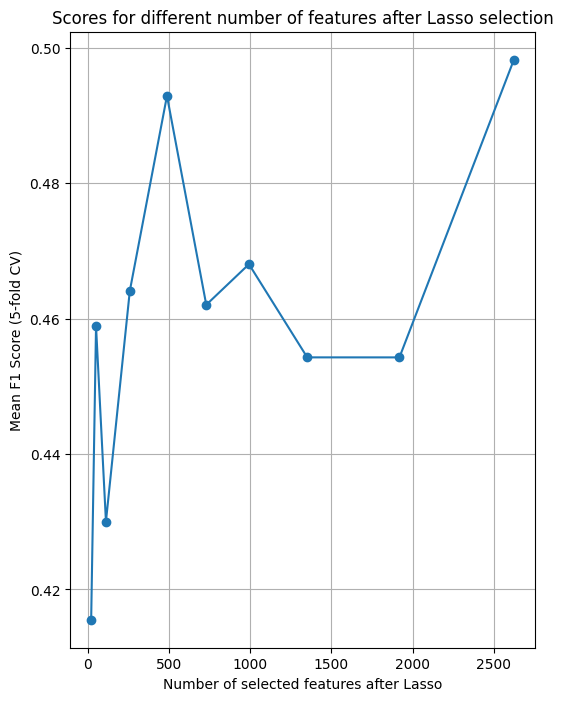

In [117]:
plt.figure(figsize = (6,8))
plt.plot(n_features,scores,marker='o')
plt.title('Scores for different number of features after Lasso selection')
plt.xlabel('Number of selected features after Lasso')
plt.ylabel('Mean F1 Score (5-fold CV)')
plt.grid()
plt.show()

In [65]:
X_train

,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,11_740,11_741,11_742,11_743,11_744,11_745,11_746,11_747,11_748,11_749
6,-0.012800,-0.165629,-0.013054,-0.340575,-0.417120,-0.418734,-0.324668,1.215479,0.000000,-0.105863,...,2.449464,2.809188,1.735012,2.557577,2.493190,2.606693,2.112876,2.276969,2.732411,3.100418
684,0.953717,0.730451,1.910663,1.858430,1.445040,-0.055822,-0.098870,0.359501,0.376431,-0.043094,...,3.324052,3.058947,2.493874,2.586568,2.321302,3.221466,2.050323,2.301678,2.937569,2.773760
622,-0.025631,-0.297686,-0.334699,-0.466399,-0.505214,-0.366496,0.245330,-0.565734,-0.375847,-0.377079,...,0.044908,-0.377882,0.072628,0.738022,-0.292520,-0.157901,0.393040,0.020343,-0.631018,0.618798
590,-0.022936,0.033056,0.290655,2.372261,0.850756,0.375353,-0.292049,0.154239,0.609592,2.373446,...,1.004229,0.854303,-0.175943,-0.139730,-0.438915,1.173350,0.203233,0.402440,0.136711,-0.007278
522,-0.019067,-0.094233,0.258240,0.805098,1.268429,0.394664,0.184864,1.817556,16.883853,7.363951,...,0.091370,0.345281,-0.566798,0.028844,-0.210005,-0.239529,-0.560067,0.582444,-0.358929,0.502358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,-0.025686,-0.234549,-0.457720,-0.373090,-0.063774,-0.248281,-0.353216,1.633352,0.141718,0.192647,...,0.613016,-0.555094,0.562981,-0.141172,0.149962,-0.262738,-0.476865,-0.132273,0.748827,0.318449
440,-0.016154,-0.333446,-0.466227,-0.547197,-0.394129,-0.336825,0.825964,-0.423419,-0.355888,-0.163178,...,1.410885,1.981650,1.472391,1.598904,0.773551,1.680955,1.158554,1.294888,1.089855,1.590634
618,1.720443,0.858627,0.529744,-0.449623,1.319836,3.821664,-0.004350,-0.285383,-0.049398,2.735960,...,5.378927,5.025873,5.202990,6.488071,4.757885,4.772503,5.619000,6.216994,4.698148,5.543528
527,3.396114,0.777209,0.025587,0.786000,1.785686,3.615338,0.147836,0.030133,-0.177108,0.956484,...,-0.321474,-0.129013,0.256587,-0.014116,-0.228515,0.383923,-0.087911,-0.072803,0.435387,-0.228934


In [122]:
# Define the pipeline
pipeline = Pipeline([
    ('feature_selection', SelectKBest()),
    ('model', SVC()),                  # Step 4: SMOTE for oversampling
])

# Define parameter grid for GridSearchCV
param_grid = {
    'feature_selection__k': [40,80,100,300,500,800],  # Threshold for SelectFromModel
    'model__kernel': ['linear']
}
# Create GridSearchCV object
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5,verbose = 2,scoring = 'f1')

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Extract selected features indices
selected_features = best_model.named_steps['feature_selection'].get_support(indices=True)
features_univariate = X_train.iloc[:,selected_features]
# Print indices of selected features
print("Selected features",X_train.iloc[:,selected_features].columns)

# Print best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Evaluate the best model on the test data

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ......feature_selection__k=40, model__kernel=linear; total time=   0.5s
[CV] END ......feature_selection__k=40, model__kernel=linear; total time=   0.4s
[CV] END ......feature_selection__k=40, model__kernel=linear; total time=   0.5s
[CV] END ......feature_selection__k=40, model__kernel=linear; total time=   0.4s
[CV] END ......feature_selection__k=40, model__kernel=linear; total time=   0.4s
[CV] END ......feature_selection__k=80, model__kernel=linear; total time=   0.5s
[CV] END ......feature_selection__k=80, model__kernel=linear; total time=   0.9s
[CV] END ......feature_selection__k=80, model__kernel=linear; total time=   0.8s
[CV] END ......feature_selection__k=80, model__kernel=linear; total time=   1.0s
[CV] END ......feature_selection__k=80, model__kernel=linear; total time=   0.8s
[CV] END .....feature_selection__k=100, model__kernel=linear; total time=   0.5s
[CV] END .....feature_selection__k=100, model__ke

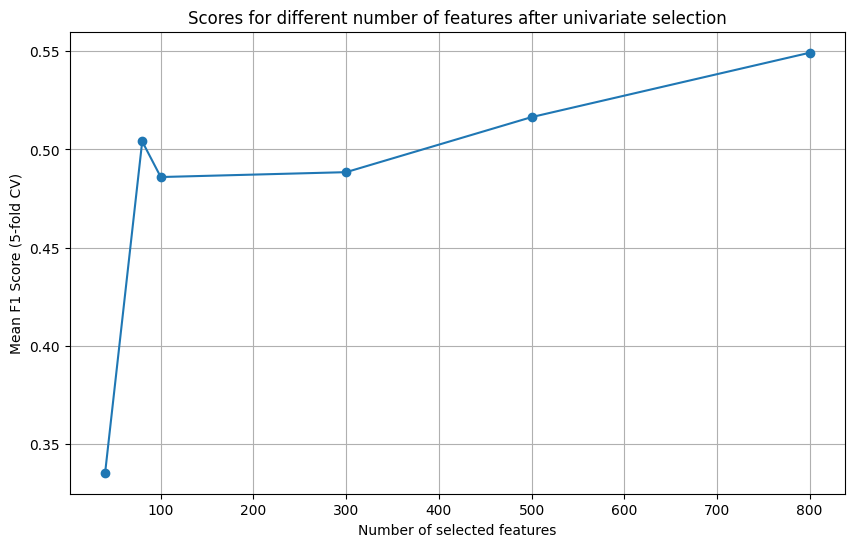

In [123]:
# Extract mean test scores and parameter values from cv_results_
mean_test_scores = grid_search.cv_results_['mean_test_score']
param_values = grid_search.cv_results_['param_feature_selection__k']

# Plot mean test scores against parameter values
plt.figure(figsize=(10, 6))
plt.plot(param_values, mean_test_scores, marker='o', linestyle='-')
plt.title('Scores for different number of features after univariate selection')
plt.xlabel('Number of selected features')
plt.ylabel('Mean F1 Score (5-fold CV)')
plt.grid()
plt.show()

Conclusion based on grid search for two different feature selection techniques:
*  Lasso feature selection: the graph shows us that the top of the graph is reached between 500 and 1000 features. This amount of features have to be selected to get the optimal F1 score. This leads to the curse of dimensionality and overfitting.
*   Univariate testing: Each added feature contributes to an increment of the F1 score. However, we found that the increment decreases as the number of selected features increase. Around the 500 selected features seems to be a flattening of the curve, thus optimal for training the data.

As we found that 500 features are preferable we are still faced with the curse of dimensionality because the number of features (500) is large comopared to the number of samples (827). Therefore we have the risk of overfitting (as we also saw in the learning curve). There are several methods of preventing overfitting. One of them is PCA: preferably you would like to capture the information of all these features in a few new features which possess the characteristics of the data (like PCA)

Other methods to mitigate the risk of overfitting when dealing with high-dimensional data, you can consider:

*   Feature Selection: Use techniques like feature selection to identify the most informative features and reduce the dimensionality of the feature space. (already done)
*   Cross-Validation: Use cross-validation to assess the generalization performance of the model and tune hyperparameters to prevent overfitting. (already done)
*   Dimensionality Reduction: Use dimensionality reduction techniques like Principal Component Analysis (PCA) or t-distributed Stochastic Neighbor Embedding (t-SNE) to project the data onto a lower-dimensional space while preserving as much variance as possible. (to be done)
*   Regularization: Apply regularization techniques like L1 (Lasso) or L2 (Ridge) regularization to penalize large coefficients and prevent overfitting. (to be done if PCA is insufficient)








### Learning curve

In [127]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

  # Now use the classifiers on all datasets
num = 0
fig = plt.figure(figsize=(6,8))
for alpha, feature_lasso in features_lasso.items():
      # Split data in training and testing
      title = f'{alpha}'
      ax = fig.add_subplot(4, 1, num + 1)
      plot_learning_curve(SVC(random_state = 1,kernel = 'linear'), title, feature_lasso, y_train, ax, ylim=(0.7, 1.1), cv=5)
      num += 1
plt.tight_layout()
fig.show()

<Figure size 600x800 with 0 Axes>

In this figure we see that the training score doesn't decrease towards the cross validation score. This is a sign of overfitting. So we should think of ways to compensate for the overfitting as mentioned above.

Discussion: because of oversampling you have copies of the training data: it is logical that the training data score is good.

In [ ]:
  # Now use the classifiers on all datasets
fig,ax = plt.subplots(figsize=(6,8))
title = 'learning curve with 800 features'
plot_learning_curve(SVC(random_state = 1,kernel = 'linear'), title, features_univariate, y_train, ax, ylim=(0.3, 1.01), cv=5)
plt.tight_layout()
plt.show()

In the figure above we see overfitting: the true and apparent error do not converge. The training score is very good but on the validation data it is not very good.

## Classifiers

In [74]:
X_train

,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,11_740,11_741,11_742,11_743,11_744,11_745,11_746,11_747,11_748,11_749
6,-0.012800,-0.165629,-0.013054,-0.340575,-0.417120,-0.418734,-0.324668,1.215479,0.000000,-0.105863,...,2.449464,2.809188,1.735012,2.557577,2.493190,2.606693,2.112876,2.276969,2.732411,3.100418
684,0.953717,0.730451,1.910663,1.858430,1.445040,-0.055822,-0.098870,0.359501,0.376431,-0.043094,...,3.324052,3.058947,2.493874,2.586568,2.321302,3.221466,2.050323,2.301678,2.937569,2.773760
622,-0.025631,-0.297686,-0.334699,-0.466399,-0.505214,-0.366496,0.245330,-0.565734,-0.375847,-0.377079,...,0.044908,-0.377882,0.072628,0.738022,-0.292520,-0.157901,0.393040,0.020343,-0.631018,0.618798
590,-0.022936,0.033056,0.290655,2.372261,0.850756,0.375353,-0.292049,0.154239,0.609592,2.373446,...,1.004229,0.854303,-0.175943,-0.139730,-0.438915,1.173350,0.203233,0.402440,0.136711,-0.007278
522,-0.019067,-0.094233,0.258240,0.805098,1.268429,0.394664,0.184864,1.817556,16.883853,7.363951,...,0.091370,0.345281,-0.566798,0.028844,-0.210005,-0.239529,-0.560067,0.582444,-0.358929,0.502358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,-0.025686,-0.234549,-0.457720,-0.373090,-0.063774,-0.248281,-0.353216,1.633352,0.141718,0.192647,...,0.613016,-0.555094,0.562981,-0.141172,0.149962,-0.262738,-0.476865,-0.132273,0.748827,0.318449
440,-0.016154,-0.333446,-0.466227,-0.547197,-0.394129,-0.336825,0.825964,-0.423419,-0.355888,-0.163178,...,1.410885,1.981650,1.472391,1.598904,0.773551,1.680955,1.158554,1.294888,1.089855,1.590634
618,1.720443,0.858627,0.529744,-0.449623,1.319836,3.821664,-0.004350,-0.285383,-0.049398,2.735960,...,5.378927,5.025873,5.202990,6.488071,4.757885,4.772503,5.619000,6.216994,4.698148,5.543528
527,3.396114,0.777209,0.025587,0.786000,1.785686,3.615338,0.147836,0.030133,-0.177108,0.956484,...,-0.321474,-0.129013,0.256587,-0.014116,-0.228515,0.383923,-0.087911,-0.072803,0.435387,-0.228934


In [ ]:
selected_features = feature_names_lasso[alphas[7]]
X_train = X_train.loc[:,selected_features]
X_test = X_test.loc[:,selected_features]
X_train

In [ ]:
import time
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Classifiers
classifiers = {
    "KNN" : KNeighborsClassifier(),
    "SVC" : SVC(random_state=0, probability=True),
    "RandomForest" : RandomForestClassifier(random_state=0)}

# Grids for grid search
KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

SVC_grid = {'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
            'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
            'gamma': ['scale', 'auto'],
            'degree': [2, 3, 4],  # degrees for polynomial kernel
            'coef0': [0.0, 0.1, 0.5]  # homogeneity parameter
            }

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [4, 6, 8, 10, 12]}

# Dictionary of all grids
grid = {
    "KNN" : KNN_grid,
    "SVC" : SVC_grid,
    "RandomForest" : RF_grid}

X_10 = X_train.iloc[:50]
y_10 = y_train.iloc[:50]
X_test_10 = X_test.iloc[:50]
y_test_10 = y_test.iloc[:50]


i=0
clf_best_params=classifiers.copy()
valid_scores=pd.DataFrame({'Classifer':classifiers.keys(), 'Validation accuracy': np.zeros(len(classifiers)), 'Training time': np.zeros(len(classifiers))})
for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

    # Train and score
    clf.fit(X_10, y_10)
    valid_scores.iloc[i,1]=clf.score(X_test_10, y_test_10)

    # Save trained model
    clf_best_params[key]=clf.best_params_

    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i,2]=np.round((stop - start)/60, 2)

    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i,2])
    print('')
    i+=1
